# Range-Bearing Example: EKF vs UKF

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In this example we consider a stationary robot with a state defined by its pose $x = [p_x, p_y, \theta]^\top$ that has a range-bearing sensor and observes a fixed landmark $l = [l_x, l_y]^\top$. In this problem, we assume there is some measurment noise, $Q$, but no dynamics noise (since the robot is stationary). The goal is to localize the robot given the known landmark position.

In the functions `range_bearing` and `range_bearing_jacobian` we define the measurement model and its Jacobian. We also define the functions `wrap_angle` and `angle_mean` as utility functions for handling the bearing measurements in the EKF and UKF.

In [2]:
def robot_dynamics(x):
    """
    The robot in this example is trivially stationary.
    """
    return x

def robot_jacobian(x):
    """
    The robot in this example is stationary, so the Jacobian
    is trivially the identity matrix.
    """
    return np.eye(x.shape[0])

def range_bearing(x, landmark):
    """
    Compute measurement [r, b] where r is the range and b is the bearing (radians)
    of the landmark with respect to the pose `x` = [px, py, θ].
    """
    px, py, th = x
    lx, ly = landmark
    dx, dy = lx - px, ly - py
    r = np.hypot(dx, dy)
    b = wrap_angle(np.arctan2(dy, dx) - th)
    return np.array([r, b])

def range_bearing_jacobian(x, landmark):
    """ 
    Compute Jacobian for the range-bearing measurement model, given a single
    landmark point and the linearization pose `x` = [px, py, θ].
    """
    px, py, th = x
    lx, ly = landmark
    dx, dy = lx - px, ly - py
    r2 = dx*dx + dy*dy
    r = np.sqrt(r2) if r2 > 1e-12 else 1e-6
    H = np.zeros((2,3))
    H[0,0] = -dx / r
    H[0,1] = -dy / r
    if r2 > 1e-12:
        H[1,0] =  dy / r2
        H[1,1] = -dx / r2
    H[1,2] = -1.0
    return H

def wrap_angle(a):
    """
    Wrap angle to the range [-π, π).
    """
    return (a + np.pi) % (2 * np.pi) - np.pi

def angle_mean(weights, angles):
    """
    Given a list of weights and angles, compute the weighted average. Computes
    the average by in Cartesian coordinates and then converts back to an angle.
    """
    s = np.sum(weights * np.sin(angles))
    c = np.sum(weights * np.cos(angles))
    return np.arctan2(s, c)

### Range-Bearing Example: EKF
We can apply the EKF algorithm to this problem using the function `ekf_update` below:

In [3]:
def ekf_update(prior_mean, prior_cov, z, Q, landmark):
    """
    Given the prior mean and covariance for the range-bearing robot problem,
    a range-bearing measurement of the landmark, and the landmark location, 
    update the mean and covariance using the EKF update.
    """
    # Prediction
    F = robot_jacobian(prior_mean)
    pred_mean = robot_dynamics(prior_mean)
    pred_cov = F @ prior_cov @ F.T

    # Innovation and gain
    H = range_bearing_jacobian(prior_mean, landmark)
    z_hat = range_bearing(pred_mean, landmark)
    innov = np.array([z[0] - z_hat[0], wrap_angle(z[1] - z_hat[1])])
    S = H @ prior_cov @ H.T + Q
    K = pred_cov @ H.T @ np.linalg.inv(S)

    # Correction
    mean = pred_mean + K @ innov
    I = np.eye(3)
    cov = (I - K @ H) @ pred_cov @ (I - K @ H).T + K @ Q @ K.T
    mean[2] = wrap_angle(mean[2])
    return mean, cov

### Range-Bearing Example: UKF
We can apply the UKF algorithm to this problem using the functions `compute_sigma_points` and `ukf_update` below:

In [4]:
def compute_sigma_points(mean, cov, alpha=0.3, beta=2.0, kappa=0.0):
    """
    Compute sigma points (and their weights) for unscented transform given the mean and
    covariance of the Gaussian.
    """
    n = mean.size
    lam = alpha**2 * (n + kappa) - n
    C = np.linalg.cholesky((n + lam) * cov)
    X = np.zeros((2*n + 1, n))
    X[0] = mean
    for i in range(n):
        X[i+1]   = mean + C[:, i]
        X[i+1+n] = mean - C[:, i]
    Wm = np.full(2*n + 1, 1.0/(2*(n + lam)))
    Wc = np.full(2*n + 1, 1.0/(2*(n + lam)))
    Wm[0] = lam / (n + lam)
    Wc[0] = lam / (n + lam) + (1 - alpha**2 + beta)
    return X, Wm, Wc

def ukf_update(prior_mean, prior_cov, z, Q, landmark):
    """
    Given the prior mean and covariance for the range-bearing robot problem,
    a range-bearing measurement of the landmark, and the landmark location, 
    update the mean and covariance using the UKF update.
    """
    # Compute sigma points and predicted mean/covariance
    X, Wm, Wc = compute_sigma_points(prior_mean, prior_cov, alpha=0.3, beta=2.0, kappa=0.0)
    Y = np.array([robot_dynamics(x) for x in X])
    pred_mean = np.zeros(3)
    pred_mean[0] = np.sum(Wm * Y[:,0])
    pred_mean[1] = np.sum(Wm * Y[:,1])
    pred_mean[2] = angle_mean(Wm, Y[:,2])

    # Compute predicted measurement
    Z = np.array([range_bearing(y, landmark) for y in Y])
    pred_z = np.zeros(2)
    pred_z[0] = np.sum(Wm * Z[:,0])
    pred_z[1] = angle_mean(Wm, Z[:,1])

    # Compute predicted covariances
    Pff = np.zeros((3,3))
    Phh = np.zeros((2,2))
    Pfh = np.zeros((3,2))
    for i in range(Y.shape[0]):
        dz = np.array([Z[i,0] - pred_z[0], wrap_angle(Z[i,1] - pred_z[1])])
        dy = Y[i] - pred_mean
        dy[2] = wrap_angle(dy[2])
        Pff += Wc[i] * np.outer(dy, dy)
        Phh += Wc[i] * np.outer(dz, dz)
        Pfh += Wc[i] * np.outer(dy, dz)

    # Compute gain and correction
    pred_cov = Pff
    S = Phh + Q
    K = Pfh @ np.linalg.inv(S)
    innov = np.array([z[0] - pred_z[0], wrap_angle(z[1] - pred_z[1])])
    mean = pred_mean + K @ innov
    mean[2] = wrap_angle(mean[2])
    cov = pred_cov - K @ S @ K.T
    return mean, cov

### Compare EKF and UKF
Run the code below to compare the EKF and UKF updates for a simple scenario.

EKF time: 0.33 ms
UKF time: 1.08 ms
Prior:
  mean: px=0.850, py=0.200, th=30.00 deg
  std : sx=0.300, sy=0.100, s_th=5.00 deg
EKF posterior:
  mean: px=0.602, py=-0.172, th=27.26 deg
  std : sx=0.046, sy=0.067, s_th=4.94 deg
UKF posterior:
  mean: px=0.274, py=0.053, th=30.15 deg
  std : sx=0.089, sy=0.085, s_th=4.98 deg


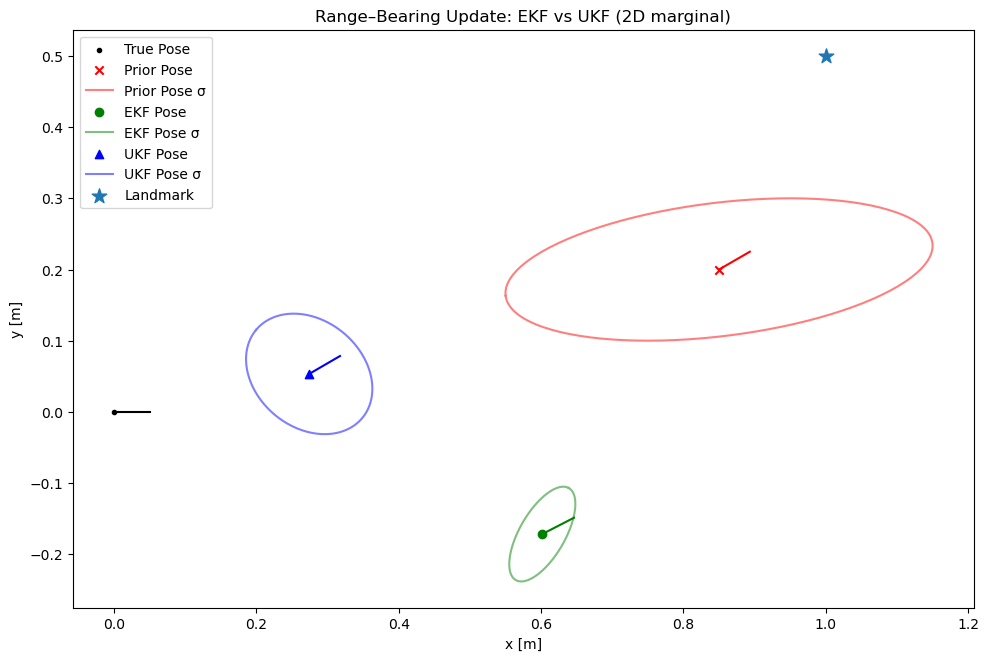

In [5]:
def cov_ellipse_points(mean, cov, nstd=2.0, num=200):
    """
    Computes a set of 2D points corresponding to `nstd` number of standard deviations
    for a 2D Gaussian given the mean and 2D covariance matrix.
    """
    vals, vecs = np.linalg.eigh(cov)
    order = np.argsort(vals)[::-1]
    vals, vecs = vals[order], vecs[:, order]
    t = np.linspace(0, 2*np.pi, num)
    w, h = nstd * np.sqrt(vals[0]), nstd * np.sqrt(vals[1])
    ellipse = (vecs @ np.diag([w, h]) @ np.vstack((np.cos(t), np.sin(t)))).T
    return ellipse[:,0] + mean[0], ellipse[:,1] + mean[1]

def summarize(label, mu, Sigma):
    sx, sy, sth = np.sqrt(np.diag(Sigma))
    print(f"{label}:")
    print(f"  mean: px={mu[0]:.3f}, py={mu[1]:.3f}, th={np.rad2deg(mu[2]):.2f} deg")
    print(f"  std : sx={sx:.3f}, sy={sy:.3f}, s_th={np.rad2deg(sth):.2f} deg")

# Prior with sizeable heading uncertainty to emphasize nonlinearity
prior_mean = np.array([0.85, 0.2, np.deg2rad(30.0)])
prior_cov = np.diag([0.30**2, 0.10**2, np.deg2rad(5.0)**2])
prior_cov[0,1] = prior_cov[1,0] = 0.5 * (0.20 * 0.10)

# Define landmark location
landmark = np.array([1.0, 0.5])

# Measurement noise covariance (range [m], bearing [rad])
Q = np.diag([0.10**2, np.deg2rad(2.5)**2])

# Synthetic measurement from a nearby true pose
x_true = np.array([0, 0, np.deg2rad(0.0)])
rng = np.random.default_rng(7)
z_true = range_bearing(x_true, landmark)
z = z_true + rng.multivariate_normal(mean=[0.0, 0.0], cov=Q)
z[1] = wrap_angle(z[1])

# EKF measurement update
start_time = time.perf_counter()
mean_ekf, cov_ekf = ekf_update(prior_mean, prior_cov, z, Q, landmark)
ekf_time = time.perf_counter() - start_time
print(f"EKF time: {1000*ekf_time:.2f} ms")

# UKF measurement update
start_time = time.perf_counter()
mean_ukf, cov_ukf = ukf_update(prior_mean, prior_cov, z, Q, landmark)
ukf_time = time.perf_counter() - start_time
print(f"UKF time: {1000*ukf_time:.2f} ms")

# Print summaries of updates
summarize("Prior", prior_mean, prior_cov)
summarize("EKF posterior", mean_ekf, cov_ekf)
summarize("UKF posterior", mean_ukf, cov_ukf)

# Plot update results
fig, ax = plt.subplots(figsize=(10,8))
def plot_pose_and_cov(x, l, color, label, marker, cov=None):
    px, py, θ = x
    ax.scatter([px], [py], color=color, marker=marker, label=label)
    ax.plot([px, px + l*np.cos(θ)], [py, py + l*np.sin(θ)], color=color)
    if cov is not None:
        x, y = cov_ellipse_points(x[:2], cov[:2,:2], nstd=1.0)
        ax.plot(x, y, label=f"{label} σ", color=color, alpha=0.5)
plot_pose_and_cov(x_true, 0.05, color='k', label="True Pose", marker=".")
plot_pose_and_cov(prior_mean, 0.05, color='r', label="Prior Pose", marker="x", cov=prior_cov)
plot_pose_and_cov(mean_ekf, 0.05, color='g', label="EKF Pose", marker="o", cov=cov_ekf)
plot_pose_and_cov(mean_ukf, 0.05, color='b', label="UKF Pose", marker="^", cov=cov_ukf)
ax.scatter([landmark[0]], [landmark[1]], marker="*", s=120, label="Landmark")
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("Range–Bearing Update: EKF vs UKF (2D marginal)")
ax.legend(loc="best")
plt.tight_layout()
plt.show()